Importing Required **Libraries**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score, confusion_matrix,classification_report,
    ConfusionMatrixDisplay )
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
warnings.filterwarnings('ignore')


Loading Kaggle **dataset**

In [16]:
from google.colab import files
files.upload()



Output hidden; open in https://colab.research.google.com to view.

In [18]:
try:

    df = pd.read_csv("Final_Balanced_Autoimmune_Disorder_Dataset.csv")
    print("Dataset has been loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure the file is uploaded correctly.")

Dataset has been loaded successfully!


# Explanatory Data Analysis (EDA)

# 1. **Intial** Data **Inspection**
Key Insights:
- Shows dataset structure (columns, data types)
- Displays sample records
- Identifies missing values in each column







# Handling Duplicate Patient Records

In this dataset, each row represents a patient’s medical record related to autoimmune disorders.  
During preprocessing, we noticed that some patients appear multiple times (**same `Patient_ID`**).

This can mean two different things:

- **Meaningful duplicates** → The same patient has multiple visits/tests with different results. These are important because they capture disease progression and variability.  
- **True duplicates** → Identical rows (exact same patient, same features, same values). These add no value and should be removed.

---

## 🔎 Steps Taken

### 1. Counted Patient Records
- Checked how many times each `Patient_ID` appears.  
- Identified patients with multiple records.

### 2. Extracted Duplicate Patients
- Pulled all rows belonging to patients with multiple entries.  
- Counted how many unique patients and total rows are affected.

### 3. Checked Variation Across Duplicates
- Grouped records by `Patient_ID` and measured how many unique values each patient had per feature.  
- This showed whether the multiple records were truly different or not.

### 4. Detected True Duplicates
- Used `df.duplicated()` to find identical rows.  
- These records were dropped since they provide no new information.

### 5. Example Inspection
- Displayed a sample patient with multiple records to manually confirm whether their data varied across visits.

### 6. Cleaned the Dataset
- Removed only **true duplicates**.  
- Kept **meaningful duplicates** (multiple visits/tests).

### 7. Added a Flag Feature
- Created a new column `Has_Multiple_Records` (**True/False**).  
- This helps the ML model learn whether patients with multiple visits behave differently from single-record patients.

---

## ✅ Final Outcome

- **Before cleaning:** `11,712 rows × 79 features`  
- **After cleaning (dropping true duplicates only):** `X rows × 79 features` (dataset shrank, but meaningful duplicates were kept).  
- Added **`Has_Multiple_Records`** feature to enrich the dataset.

---

👉 This approach ensures we **preserve medically meaningful variability** while removing unnecessary duplicates.  
👉 When training ML models, we’ll use **GroupKFold by `Patient_ID`** to avoid data leakage (a patient appearing in both train and test).






# 2. **Target** Variable Analysis
   # Visualizations

In [19]:
# ===============================
#  Exploratory Data Analysis (EDA)
# ===============================

# Convert Patient_ID to object (string)
df['Patient_ID'] = df['Patient_ID'].astype(object)

# Verify change
print(df['Patient_ID'].dtype)

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- First 5 Rows ---")
display(df.head())


print("\n--- Last 5 Rows ---")
display(df.tail())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Dataset Shape ---")
print(df.shape)

print("\n--- Describe Dataset ---")
print(df.describe())

#converting colunm name to a python list
print("\n--- Column names ---")
df.columns.tolist()

#checking categorical/numeric diversity
print("\n--- unique values ---")
display(df.nunique())

#checking duplicate values
print("\n--- Duplicate Values ---")
for col in df.columns:
    duplicates = df[col].duplicated().sum()
    print(f"{col}: {duplicates} duplicate values")



# --- Step 1: Count patient occurrences ---
patient_counts = df['Patient_ID'].value_counts()
print("\nTop patients with multiple records:")
print(patient_counts.head(10))

# --- Step 2: Extract all duplicate patients ---
duplicate_patients = df[df.duplicated(subset=['Patient_ID'], keep=False)]
print("\nPatients with multiple records:", duplicate_patients['Patient_ID'].nunique())
print("Total duplicate patient records:", duplicate_patients.shape[0])

# --- Step 3: Variation check across duplicates ---
variation = duplicate_patients.groupby("Patient_ID").nunique()
print("\nFeature variation for duplicate patients (how many unique values per column):")
display(variation.head())

# --- Step 4: Detect true duplicates (identical rows) ---
true_duplicates = df[df.duplicated(keep=False)]
print("\nTrue duplicates (identical rows):", true_duplicates.shape[0])

# --- Step 5: Example patient records (to manually inspect differences) ---
example_id = patient_counts[patient_counts > 1].index[0]  # pick a patient with >1 record
print(f"\nExample records for Patient_ID {example_id}:")
display(df[df['Patient_ID'] == example_id])

# --- Step 6: Clean dataset ---
# Drop only true duplicates, keep meaningful duplicates
df_cleaned = df.drop_duplicates()

# --- Step 7: Add flag for patients with multiple records ---
df_cleaned['Has_Multiple_Records'] = df_cleaned['Patient_ID'].isin(
    patient_counts[patient_counts > 1].index
)

print("\n--- Dataset shape before cleaning ---")
print(df.shape)

print("\n--- Dataset shape after removing true duplicates ---")
print(df_cleaned.shape)

print("\n--- Example with Has_Multiple_Records flag ---")
display(df_cleaned[['Patient_ID', 'Has_Multiple_Records']].head(10))









object

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712 entries, 0 to 11711
Data columns (total 79 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient_ID                            11712 non-null  object 
 1   Age                                   11712 non-null  int64  
 2   Gender                                11712 non-null  object 
 3   Diagnosis                             11712 non-null  object 
 4   Sickness_Duration_Months              11712 non-null  int64  
 5   RBC_Count                             11712 non-null  float64
 6   Hemoglobin                            11712 non-null  float64
 7   Hematocrit                            11712 non-null  float64
 8   MCV                                   11712 non-null  float64
 9   MCH                                   11712 non-null  float64
 10  MCHC                                  11712 non-null 

Patient_ID  Age  Gender            Diagnosis  Sickness_Duration_Months  \
0          6   62    Male  Autoimmune orchitis                        41   
1         20   54  Female  Autoimmune orchitis                        41   
2         46   34    Male  Autoimmune orchitis                        86   
3        108   22    Male  Autoimmune orchitis                        43   
4        142   20  Female  Autoimmune orchitis                        50   

   RBC_Count  Hemoglobin  Hematocrit     MCV    MCH  ...  Anti_TIF1  \
0       4.75       13.37       43.11  101.91  28.41  ...          0   
1       4.32       10.76       39.92   95.96  28.22  ...          0   
2       4.42       11.91       38.38   80.56  28.40  ...          0   
3       4.33       12.72       39.99   84.71  26.67  ...          0   
4       3.99       11.07       43.58   89.87  30.64  ...          0   

   Anti_epidermal_basement_membrane_IgA  Anti_OmpC  pANCA  \
0                                     0          0      0   
1                                     0          0      0   
2                                     0          0      0   
3                                     0          0      0   
4                                     0          0      0   

   Anti_tissue_transglutaminase  anti_Scl_70  Anti_Mi2  Anti_parietal_cell  \
0                             0            0         0                   0   
1                             0            0         0                   0   
2                             0            0         0                   0   
3                             0            0         0                   0   
4                             0            0         0                   0   

   Progesterone_antibodies  Anti_Sm  
0                        0        0  
1                        0        0  
2                        0        0  
3                        0        0  
4                        0        0  

[5 rows x 79 columns]


--- Last 5 Rows ---


Patient_ID  Age  Gender Diagnosis  Sickness_Duration_Months  RBC_Count  \
11707       6950   40  Female     Other                        60       4.57   
11708       5579   20  Female     Other                        21       4.14   
11709       9999   27    Male     Other                        43       3.85   
11710       5312   76    Male     Other                        80       4.85   
11711       6950   40  Female     Other                        60       4.57   

       Hemoglobin  Hematocrit    MCV    MCH  ...  Anti_TIF1  \
11707       13.77       40.85  93.25  27.12  ...          0   
11708       12.35       42.15  86.16  29.15  ...          0   
11709       11.26       38.35  79.00  26.59  ...          0   
11710       12.32       37.83  78.01  29.99  ...          0   
11711       13.77       40.85  93.25  27.12  ...          0   

       Anti_epidermal_basement_membrane_IgA  Anti_OmpC  pANCA  \
11707                                     1          0      0   
11708                                     0          0      0   
11709                                     0          0      0   
11710                                     0          0      0   
11711                                     1          0      0   

       Anti_tissue_transglutaminase  anti_Scl_70  Anti_Mi2  \
11707                             0            0         0   
11708                             0            0         0   
11709                             0            0         0   
11710                             0            0         0   
11711                             0            0         0   

       Anti_parietal_cell  Progesterone_antibodies  Anti_Sm  
11707                   0                        0        0  
11708                   0                        0        0  
11709                   0                        0        0  
11710                   0                        0        0  
11711                   0                        0        0  

[5 rows x 79 columns]


--- Missing Values ---
Patient_ID                  0
Age                         0
Gender                      0
Diagnosis                   0
Sickness_Duration_Months    0
                           ..
anti_Scl_70                 0
Anti_Mi2                    0
Anti_parietal_cell          0
Progesterone_antibodies     0
Anti_Sm                     0
Length: 79, dtype: int64

--- Dataset Shape ---
(11712, 79)

--- Describe Dataset ---
                Age  Sickness_Duration_Months     RBC_Count    Hemoglobin  \
count  11712.000000              11712.000000  11712.000000  11712.000000   
mean      49.332223                 62.094348      4.273274     12.508963   
std       17.307711                 33.779429      0.444560      1.464328   
min       20.000000                  1.000000      3.510000     10.000000   
25%       35.000000                 34.000000      3.880000     11.230000   
50%       48.000000                 62.000000      4.300000     12.410000   
75%       65.000000  

Patient_ID                  643
Age                          60
Gender                        2
Diagnosis                     6
Sickness_Duration_Months    119
                           ... 
anti_Scl_70                   2
Anti_Mi2                      2
Anti_parietal_cell            2
Progesterone_antibodies       1
Anti_Sm                       2
Length: 79, dtype: int64


--- Duplicate Values ---
Patient_ID: 11069 duplicate values
Age: 11652 duplicate values
Gender: 11710 duplicate values
Diagnosis: 11706 duplicate values
Sickness_Duration_Months: 11593 duplicate values
RBC_Count: 11562 duplicate values
Hemoglobin: 11345 duplicate values
Hematocrit: 11246 duplicate values
MCV: 11143 duplicate values
MCH: 11317 duplicate values
MCHC: 11354 duplicate values
RDW: 11388 duplicate values
Reticulocyte_Count: 11500 duplicate values
WBC_Count: 11094 duplicate values
Neutrophils: 11119 duplicate values
Lymphocytes: 11129 duplicate values
Monocytes: 11271 duplicate values
Eosinophils: 11400 duplicate values
Basophils: 11612 duplicate values
PLT_Count: 11069 duplicate values
MPV: 11363 duplicate values
ANA: 11710 duplicate values
Esbach: 11479 duplicate values
MBL_Level: 11563 duplicate values
ESR: 11671 duplicate values
C3: 11601 duplicate values
C4: 11661 duplicate values
CRP: 11244 duplicate values
Anti-dsDNA: 11710 duplicate values
Anti-Sm: 11710 duplicate va

Age  Gender  Diagnosis  Sickness_Duration_Months  RBC_Count  \
Patient_ID                                                                
6             1       1          1                         1          1   
14            1       1          1                         1          1   
20            1       1          1                         1          1   
46            1       1          1                         1          1   
52            1       1          1                         1          1   

            Hemoglobin  Hematocrit  MCV  MCH  MCHC  ...  Anti_TIF1  \
Patient_ID                                          ...              
6                    1           1    1    1     1  ...          1   
14                   1           1    1    1     1  ...          1   
20                   1           1    1    1     1  ...          1   
46                   1           1    1    1     1  ...          1   
52                   1           1    1    1     1  ...          1   

            Anti_epidermal_basement_membrane_IgA  Anti_OmpC  pANCA  \
Patient_ID                                                           
6                                              1          1      1   
14                                             1          1      1   
20                                             1          1      1   
46                                             1          1      1   
52                                             1          1      1   

            Anti_tissue_transglutaminase  anti_Scl_70  Anti_Mi2  \
Patient_ID                                                        
6                                      1            1         1   
14                                     1            1         1   
20                                     1            1         1   
46                                     1            1         1   
52                                     1            1         1   

            Anti_parietal_cell  Progesterone_antibodies  Anti_Sm  
Patient_ID                                                        
6                            1                        1        1  
14                           1                        1        1  
20                           1                        1        1  
46                           1                        1        1  
52                           1                        1        1  

[5 rows x 78 columns]


True duplicates (identical rows): 11710

Example records for Patient_ID 6547:


Patient_ID  Age  Gender                           Diagnosis  \
2548        6547   58  Female                Rheumatoid arthritis   
2610        6547   58  Female                Rheumatoid arthritis   
2741        6547   58  Female                Rheumatoid arthritis   
2774        6547   58  Female                Rheumatoid arthritis   
2787        6547   58  Female                Rheumatoid arthritis   
2814        6547   58  Female                Rheumatoid arthritis   
2819        6547   58  Female                Rheumatoid arthritis   
2890        6547   58  Female                Rheumatoid arthritis   
3129        6547   58  Female                Rheumatoid arthritis   
3296        6547   58  Female                Rheumatoid arthritis   
3449        6547   58  Female                Rheumatoid arthritis   
3487        6547   58  Female                Rheumatoid arthritis   
3489        6547   58  Female                Rheumatoid arthritis   
3741        6547   58  Female                Rheumatoid arthritis   
3815        6547   58  Female                Rheumatoid arthritis   
3870        6547   58  Female                Rheumatoid arthritis   
3932        6547   58  Female                Rheumatoid arthritis   
3967        6547   58  Female                Rheumatoid arthritis   
3992        6547   58  Female                Rheumatoid arthritis   
4012        6547   58  Female                Rheumatoid arthritis   
4017        6547   58  Female                Rheumatoid arthritis   
4084        6547   58  Female                Rheumatoid arthritis   
4101        6547   58  Female                Rheumatoid arthritis   
4149        6547   58  Female                Rheumatoid arthritis   
4183        6547   58  Female                Rheumatoid arthritis   
4184        6547   58  Female                Rheumatoid arthritis   
4294        6547   58  Female                Rheumatoid arthritis   
4455        6547   58  Female                Rheumatoid arthritis   
4571        6547   58  Female                Rheumatoid arthritis   
9203        6547   58  Female  Systemic lupus erythematosus (SLE)   
9297        6547   58  Female  Systemic lupus erythematosus (SLE)   
9652        6547   58  Female  Systemic lupus erythematosus (SLE)   
9705        6547   58  Female  Systemic lupus erythematosus (SLE)   
9711        6547   58  Female  Systemic lupus erythematosus (SLE)   
9876        6547   58  Female  Systemic lupus erythematosus (SLE)   
9976        6547   58  Female  Systemic lupus erythematosus (SLE)   
10084       6547   58  Female  Systemic lupus erythematosus (SLE)   
10341       6547   58  Female  Systemic lupus erythematosus (SLE)   
10697       6547   58  Female  Systemic lupus erythematosus (SLE)   
10771       6547   58  Female  Systemic lupus erythematosus (SLE)   
10827       6547   58  Female  Systemic lupus erythematosus (SLE)   
10881       6547   58  Female  Systemic lupus erythematosus (SLE)   
10903       6547   58  Female  Systemic lupus erythematosus (SLE)   
10927       6547   58  Female  Systemic lupus erythematosus (SLE)   
11056       6547   58  Female  Systemic lupus erythematosus (SLE)   
11092       6547   58  Female  Systemic lupus erythematosus (SLE)   
11119       6547   58  Female  Systemic lupus erythematosus (SLE)   
11235       6547   58  Female  Systemic lupus erythematosus (SLE)   
11437       6547   58  Female  Systemic lupus erythematosus (SLE)   

       Sickness_Duration_Months  RBC_Count  Hemoglobin  Hematocrit    MCV  \
2548                         56       3.55       11.81        39.0  80.01   
2610                         56       3.55       11.81        39.0  80.01   
2741                         56       3.55       11.81        39.0  80.01   
2774                         56       3.55       11.81        39.0  80.01   
2787                         56       3.55       11.81        39.0  80.01   
2814                         56       3.55       11.81        39.0  80.01   
2819            


--- Dataset shape before cleaning ---
(11712, 79)

--- Dataset shape after removing true duplicates ---
(685, 80)

--- Example with Has_Multiple_Records flag ---


Patient_ID  Has_Multiple_Records
0          6                  True
1         20                  True
2         46                  True
3        108                  True
4        142                  True
5        267                  True
6        360                  True
7        421                  True
8        478                  True
9        615                  True

**Target Variable Distribution**


--- Target Variable Distribution ---
Diagnosis
Autoimmune orchitis                   21.26%
Systemic lupus erythematosus (SLE)    20.41%
Rheumatoid arthritis                  19.72%
Sjögren syndrome                      18.78%
Graves' disease                       18.72%
Other                                  1.11%
Name: proportion, dtype: object


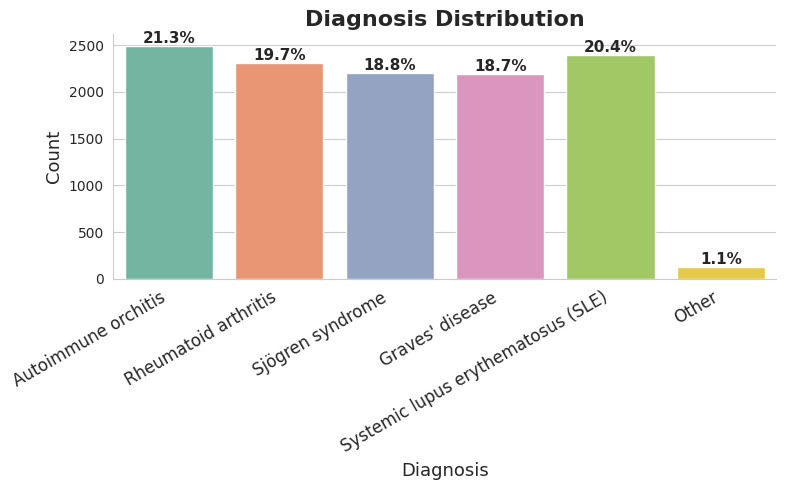

In [20]:
# Print distribution summary
print("\n--- Target Variable Distribution ---")
print(df['Diagnosis'].value_counts(normalize=True).map("{:.2%}".format))

sns.set_style("whitegrid")

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='Diagnosis', palette='Set2')

plt.title("Diagnosis Distribution", fontsize=16, weight='bold')
plt.xlabel("Diagnosis", fontsize=13)
plt.ylabel("Count", fontsize=13)

# Rotating  x labels to avoid touching
plt.xticks(rotation=30, ha='right', fontsize=12)

# Add percentages
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = f'{100 * count / total:.1f}%'
    ax.annotate(percent,
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=11, weight='bold')

sns.despine()
plt.tight_layout()
plt.show()


# Categorical Features Analysis
 **Features** **Examined**
 - Gender

 **Insights:**

- Relationship between categorical features and disease diagnosis
- Potential patterns in diagnosis rates across categories

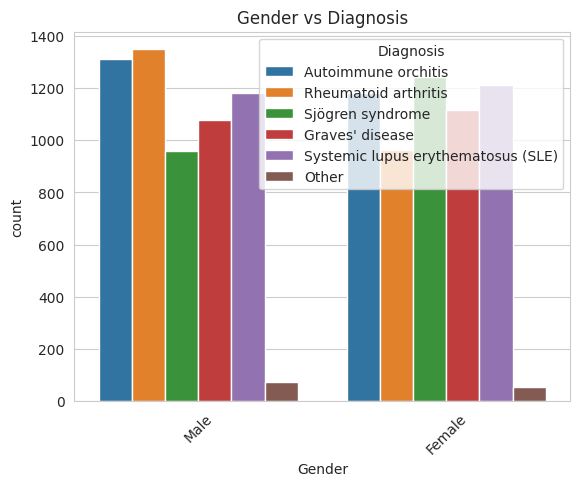

In [21]:
# Visualizing categorical features
def plot_categorical(feature):
    sns.countplot(data=df, x=feature, hue='Diagnosis')
    plt.title(f"{feature} vs Diagnosis")
    plt.xticks(rotation=45)
    plt.show()
categorical_features = ['Gender']
for feature in categorical_features:
    plot_categorical(feature)

#4. Numerical Features Analysis
**Distributions Visualized:**

Applicant Income
Co-applicant Income
Loan Amount

**Key Observations:**

- Skewness in distributions
- Outlier detection
- Data spread characteristics

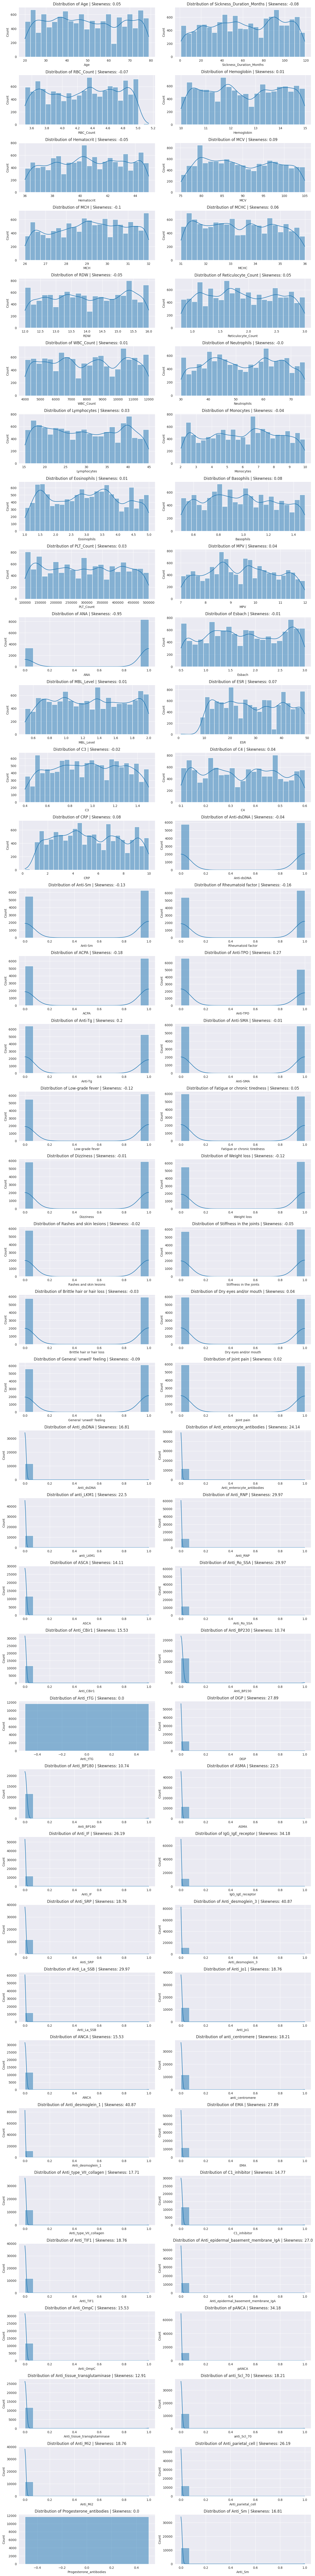

In [22]:
#understanding variance of the dataset
sns.set_style("darkgrid")

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()


**Checking for Outliers using Boxplots**

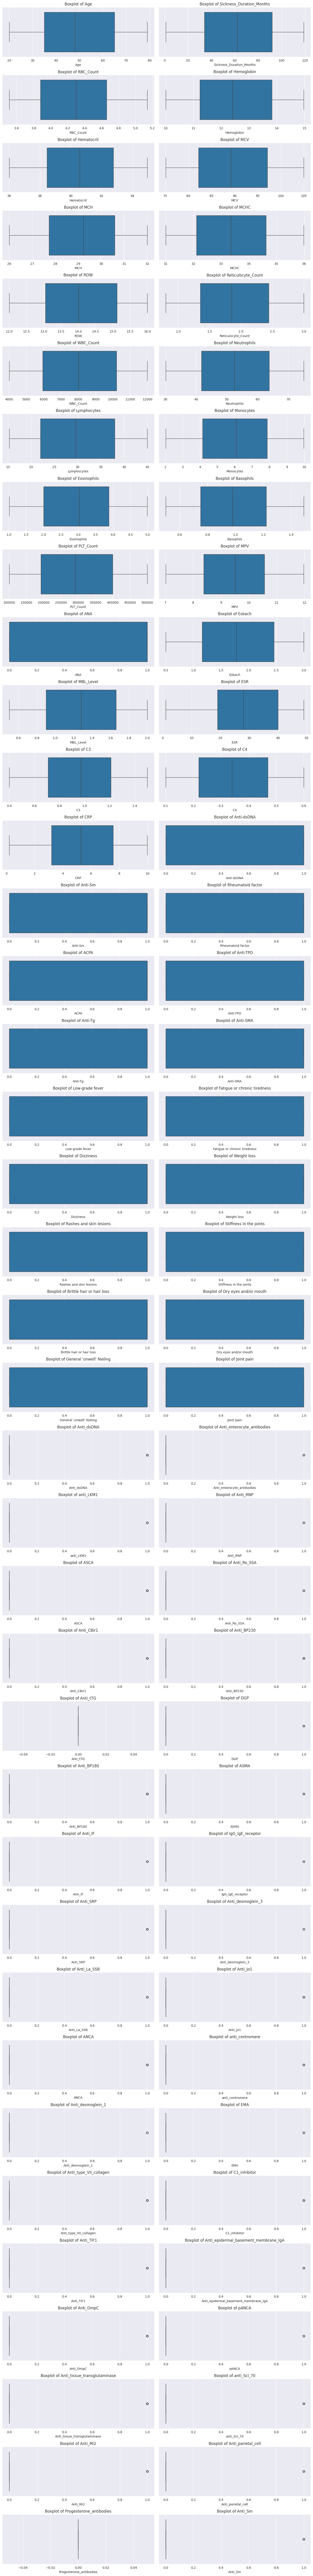

In [23]:


numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(14, len(numeric_cols)*3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


**Checking for Outliers Using Isolation Forest For Flareup Observation**

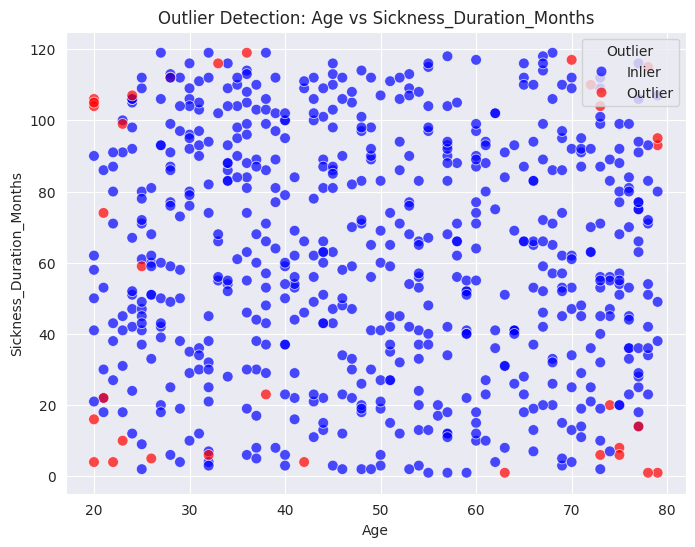

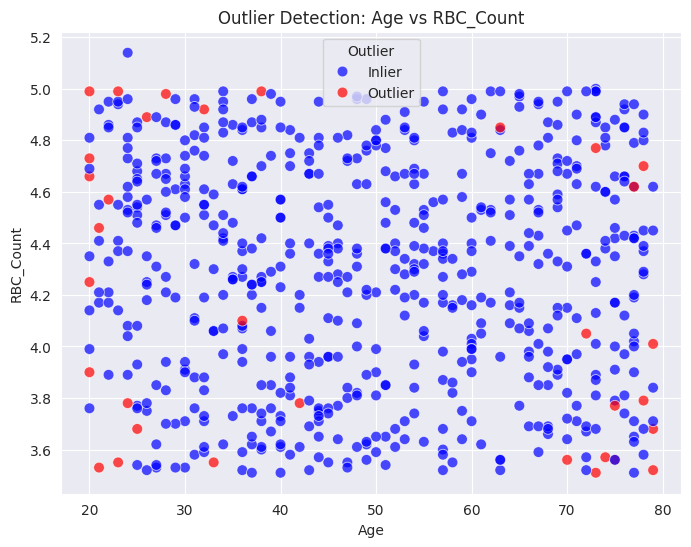

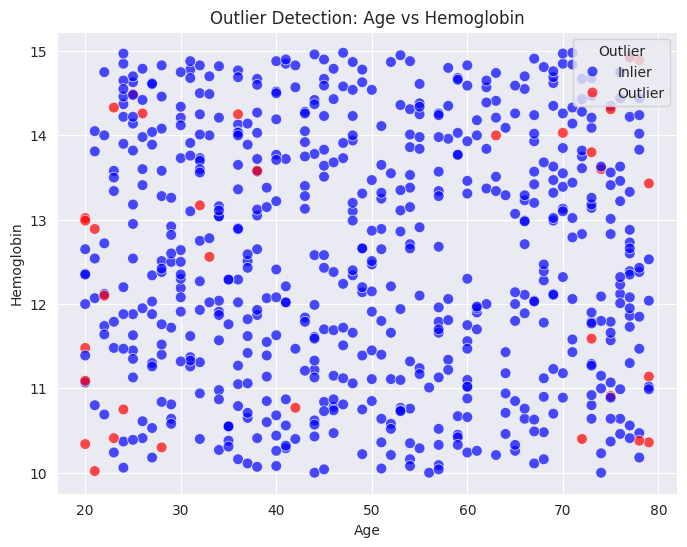

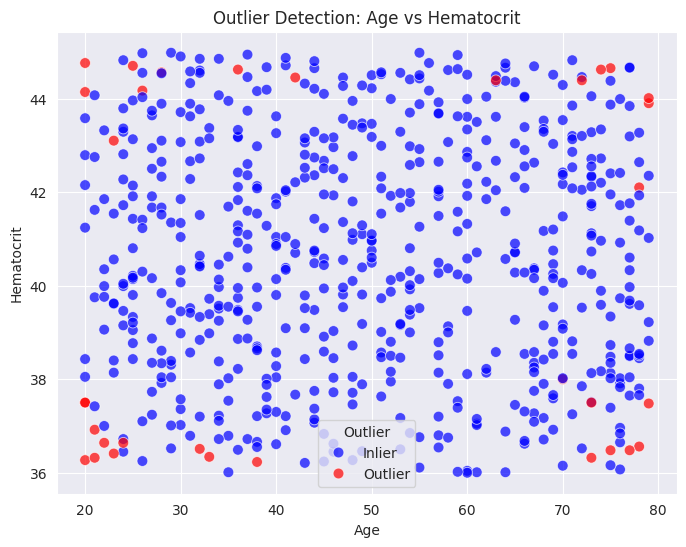

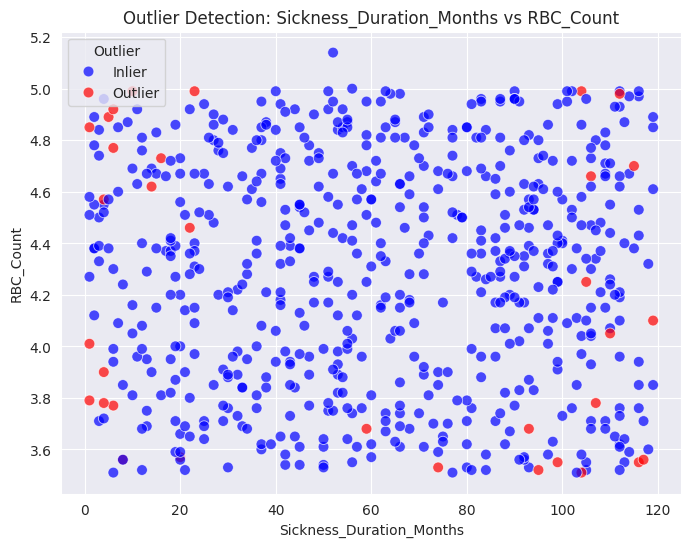

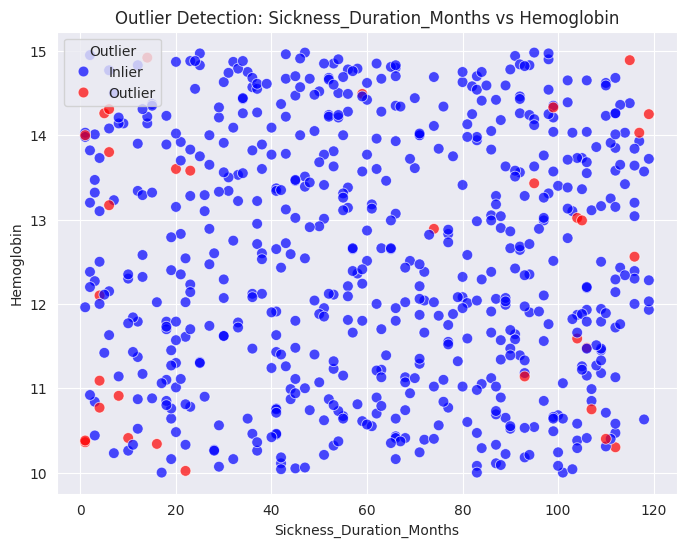

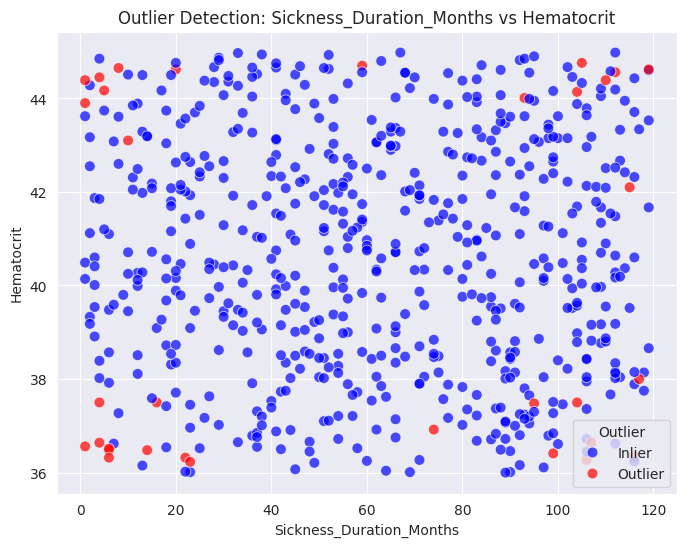

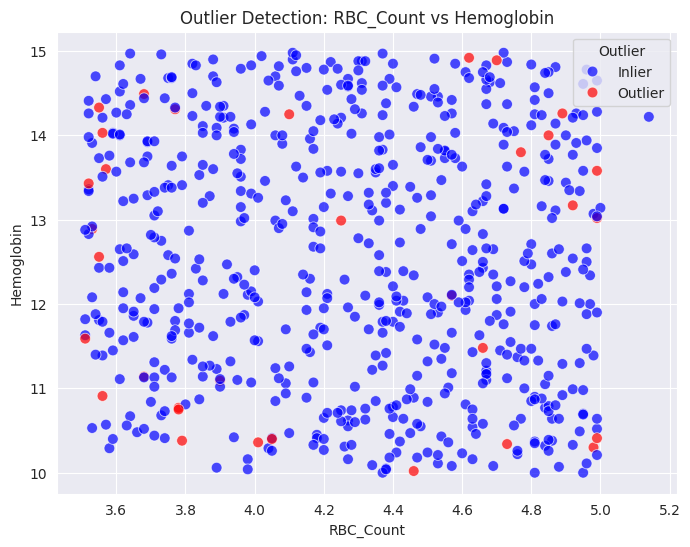

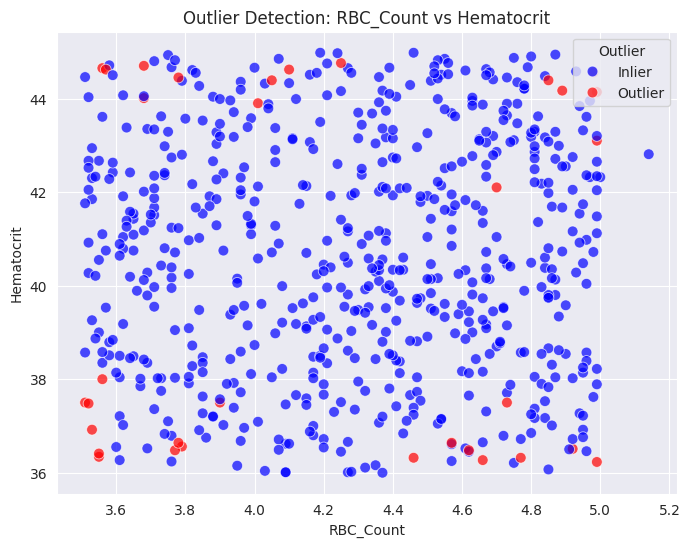

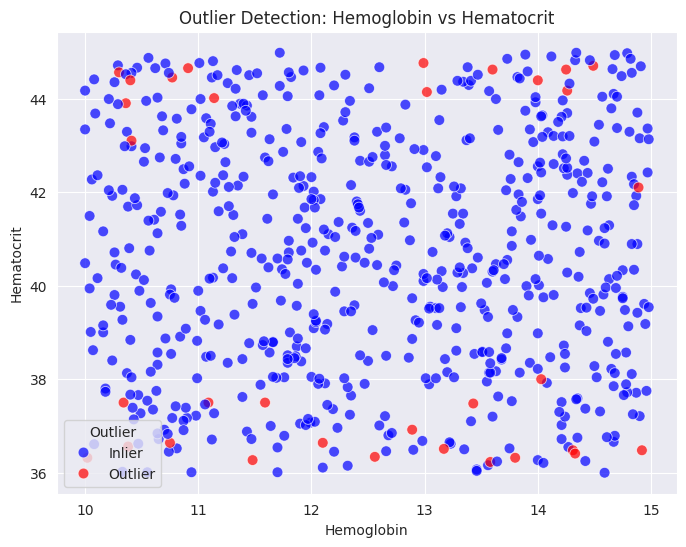

ValueError: Could not interpret value `Diagnosis` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [41]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd

# -------------------------------
# 1. Select key numerical features
# -------------------------------
# Use df_numeric which contains the processed numeric data
numeric_features = ["Age", "Sickness_Duration_Months", "RBC_Count", "Hemoglobin", "Hematocrit"]
X = df_numeric[numeric_features].dropna()

# -------------------------------
# 2. Scale data
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 3. Isolation Forest
# -------------------------------
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso.fit_predict(X_scaled)

# Add results back
# Use the index from the DataFrame used for fitting Isolation Forest
df_outliers = df_numeric.loc[X.index].copy()
df_outliers["Outlier"] = outlier_labels
df_outliers["Outlier"] = df_outliers["Outlier"].map({1: "Inlier", -1: "Outlier"})

# Merge original Diagnosis column back for plotting
df_outliers = df_outliers.merge(df_unique[['Diagnosis']], left_index=True, right_index=True, how='left')


# -------------------------------
# 4a. Scatterplots with Outliers
# -------------------------------
feature_pairs = list(combinations(numeric_features, 2))

for (x_feature, y_feature) in feature_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_outliers,
        x=x_feature,
        y=y_feature,
        hue="Outlier",
        palette={"Inlier": "blue", "Outlier": "red"},
        alpha=0.7,
        s=60
    )
    plt.title(f"Outlier Detection: {x_feature} vs {y_feature}")
    plt.show()

# -------------------------------
# 4b. Scatterplots with Diagnosis Overlay
# -------------------------------
for (x_feature, y_feature) in feature_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_outliers,
        x=x_feature,
        y=y_feature,
        hue="Diagnosis",  # overlay by disease
        style="Outlier",  # differentiate Outliers vs Inliers
        palette="tab10",
        alpha=0.7,
        s=60
    )
    plt.title(f"Outlier Detection by Diagnosis: {x_feature} vs {y_feature}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# -------------------------------
# 4c. Boxplots (Inlier vs Outlier per feature)
# -------------------------------
for feature in numeric_features:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=df_outliers,
        x="Outlier",
        y=feature,
        palette={"Inlier": "lightblue", "Outlier": "salmon"}
    )
    sns.stripplot(
        data=df_outliers,
        x="Outlier",
        y=feature,
        color="black",
        alpha=0.5,
        jitter=True
    )
    plt.title(f"Boxplot of {feature}: Inliers vs Outliers")
    plt.show()

# -------------------------------
# 5. Outlier Summary
# -------------------------------
print("\n--- Outlier Summary ---")
print(df_outliers["Outlier"].value_counts())

print("\n--- Outliers per Diagnosis ---")
print(df_outliers.groupby(["Diagnosis", "Outlier"]).size())

**Relationship between Numerical Features and Target Variable**

In [25]:

numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features = [f for f in numeric_features if f != "Patient_ID"]  # exclude ID

plt.figure(figsize=(20, len(numeric_features) * 4))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 2, i)
    sns.boxplot(data=df, x="Diagnosis", y=feature)
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs Diagnosis")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

**Correlation Heatmap**

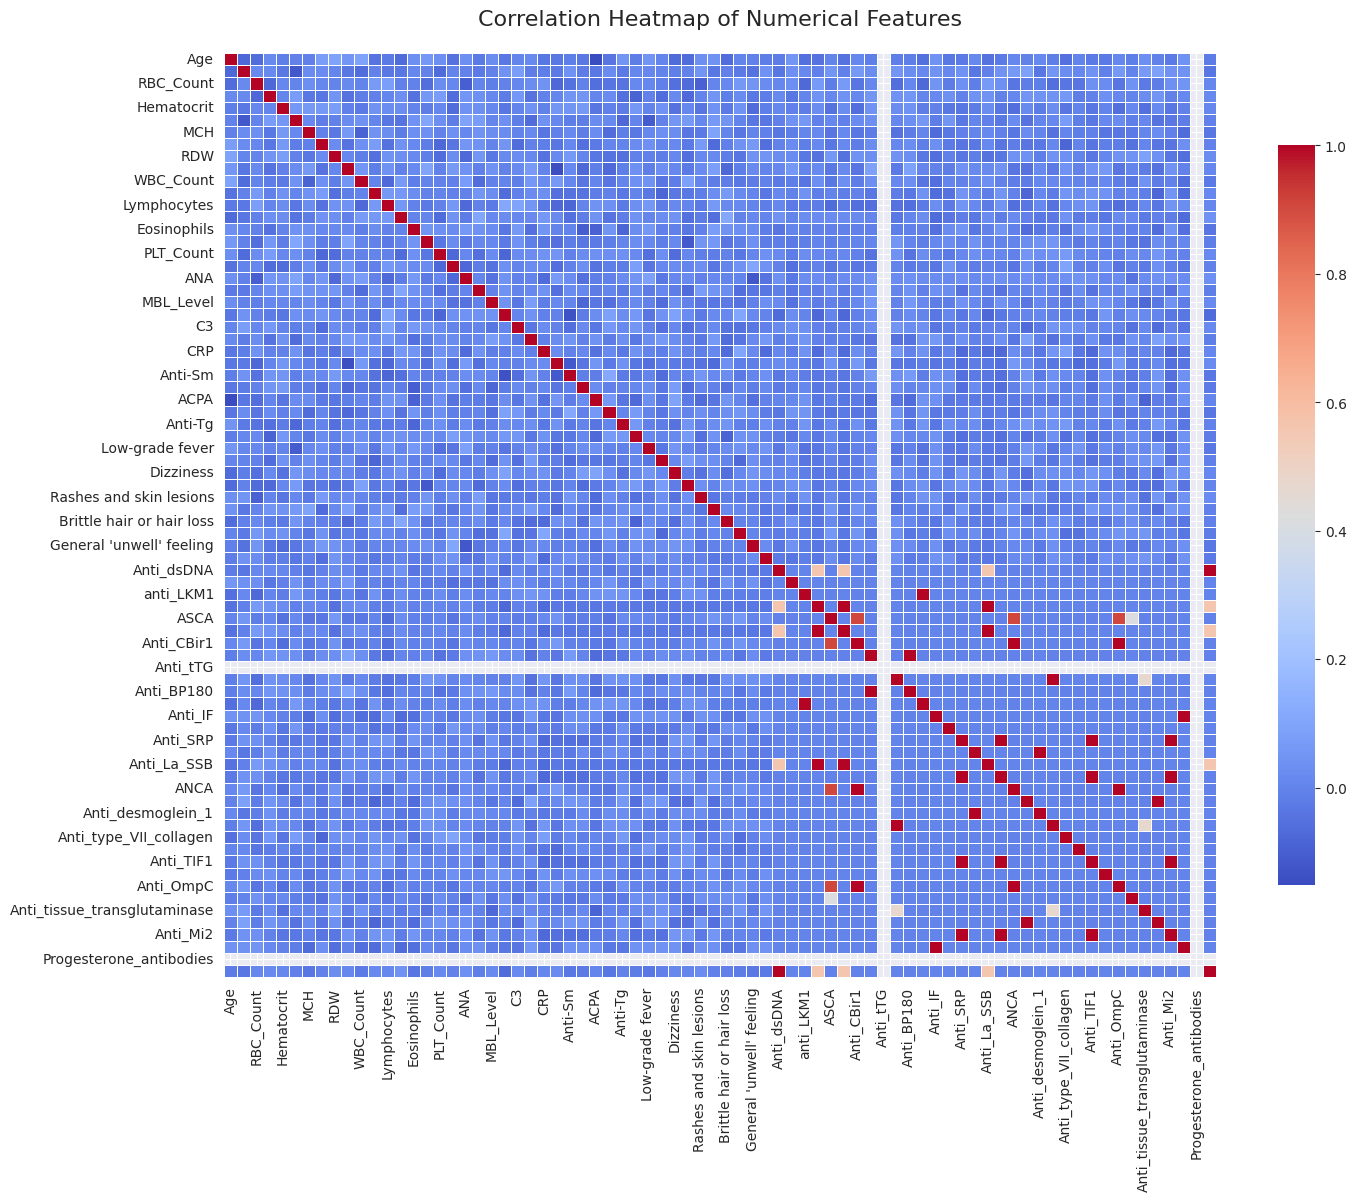


Top correlated feature pairs:
Anti_OmpC  ASCA    0.909328
dtype: float64


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical features (ignore Patient_ID and target)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['Patient_ID']]

# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,   # set to True if you want correlation values shown
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, pad=20)
plt.show()

# Optional: Show top correlated feature pairs
corr_pairs = (
    corr_matrix.unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
print("\nTop correlated feature pairs:")
print(corr_pairs[(corr_pairs < 1) & (corr_pairs > 0.8)].head(10))


# Data Preprocessing

1. **Target variable Encoding Encodes Diagnosis to either 0,1,2,3 and etc Label Encoding (Multi-class Target)**

In [27]:

# ===============================
#  Data Preprocessing section
# ===============================


# Encode target variable (multi-class classification)
# Encode Diagnosis into numeric label

# Label encode Diagnosis for unique patient rows
# Step 1: Keep only unique patients (one row per Patient_ID)
df_unique = df_cleaned.drop_duplicates(subset=["Patient_ID"], keep="first").copy()

print("--- Dataset shape after keeping unique patients ---")
print(df_unique.shape)

# Step 2: Encode Diagnosis
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_unique["Diagnosis_encoded"] = le.fit_transform(df_unique["Diagnosis"])

# Step 3: Mapping for interpretability
diagnosis_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Diagnosis Mapping:", diagnosis_mapping)


--- Dataset shape after keeping unique patients ---
(643, 80)
Diagnosis Mapping: {'Autoimmune orchitis': np.int64(0), "Graves' disease": np.int64(1), 'Rheumatoid arthritis': np.int64(2), 'Sjögren syndrome': np.int64(3), 'Systemic lupus erythematosus (SLE)': np.int64(4)}


2. **Feature Engineering One-Hot Encoding Converts categorical variables to binary columns:**

In [28]:

# One-hot encode categorical features
categorical_to_encode = ["Gender"]
df_encoded = pd.get_dummies(df_unique, columns=categorical_to_encode, drop_first=True)

print("--- Shape after One-Hot Encoding ---")
print(df_encoded.shape)


print(df_encoded.head())


--- Shape after One-Hot Encoding ---
(643, 81)
  Patient_ID  Age            Diagnosis  Sickness_Duration_Months  RBC_Count  \
0          6   62  Autoimmune orchitis                        41       4.75   
1         20   54  Autoimmune orchitis                        41       4.32   
2         46   34  Autoimmune orchitis                        86       4.42   
3        108   22  Autoimmune orchitis                        43       4.33   
4        142   20  Autoimmune orchitis                        50       3.99   

   Hemoglobin  Hematocrit     MCV    MCH   MCHC  ...  pANCA  \
0       13.37       43.11  101.91  28.41  34.98  ...      0   
1       10.76       39.92   95.96  28.22  31.70  ...      0   
2       11.91       38.38   80.56  28.40  35.21  ...      0   
3       12.72       39.99   84.71  26.67  31.25  ...      0   
4       11.07       43.58   89.87  30.64  32.77  ...      0   

   Anti_tissue_transglutaminase  anti_Scl_70  Anti_Mi2  Anti_parietal_cell  \
0                    

3. **Non-Numeric Column Removal (like Patient_ID)**

- First get list of numeric columns (excluding Diagnosis)
- Create new dataframe with only numeric features and target

In [29]:
# Drop identifier column
df_clean = df_encoded.drop(columns=["Patient_ID"])

# Get numeric columns
numeric_features = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Ensure target is included
if "Diagnosis_encoded" not in numeric_features:
    numeric_features = numeric_features + ["Diagnosis_encoded"]

# Create numeric-only dataframe
df_numeric = df_clean[numeric_features].copy()

print("Numeric dataset shape:", df_numeric.shape)
print(df_numeric.head())


Numeric dataset shape: (643, 77)
   Age  Sickness_Duration_Months  RBC_Count  Hemoglobin  Hematocrit     MCV  \
0   62                        41       4.75       13.37       43.11  101.91   
1   54                        41       4.32       10.76       39.92   95.96   
2   34                        86       4.42       11.91       38.38   80.56   
3   22                        43       4.33       12.72       39.99   84.71   
4   20                        50       3.99       11.07       43.58   89.87   

     MCH   MCHC    RDW  Reticulocyte_Count  ...  \
0  28.41  34.98  12.12                2.77  ...   
1  28.22  31.70  12.89                2.98  ...   
2  28.40  35.21  12.73                1.35  ...   
3  26.67  31.25  14.62                1.63  ...   
4  30.64  32.77  14.45                2.12  ...   

   Anti_epidermal_basement_membrane_IgA  Anti_OmpC  pANCA  \
0                                     0          0      0   
1                                     0          0      0   
2 

4. **Feature Scaling Standardizes numerical features to mean=0, variance=1:**

In [30]:
# --- 1. Separate features (X) and target (y) ---
X_full = df_numeric.drop(columns=["Diagnosis_encoded"])  # all features
y = df_numeric["Diagnosis_encoded"]

print("Original feature count:", X_full.shape[1])

# --- 2. Scale only features ---

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Wrap scaled features back into DataFrame with proper column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X_full.columns)
print("Scaled feature matrix shape:", X_scaled_df.shape)






Original feature count: 76
Scaled feature matrix shape: (643, 76)


5. **Feature Selection Selects top 10 most important features using ANOVA F-test:**

--- Top 10 Selected Features ---
                        Feature   F_Score
4                    Anti_BP230  3.849461
5                    Anti_BP180  3.849461
1                       Anti-Tg  2.956745
2                          ASCA  2.860609
0                     PLT_Count  2.575881
9  Anti_tissue_transglutaminase  2.372956
3                    Anti_CBir1  2.372956
6                          ANCA  2.372956
8                     Anti_OmpC  2.372956
7                  C1_inhibitor  2.372956
Shape after feature selection: (643, 10)


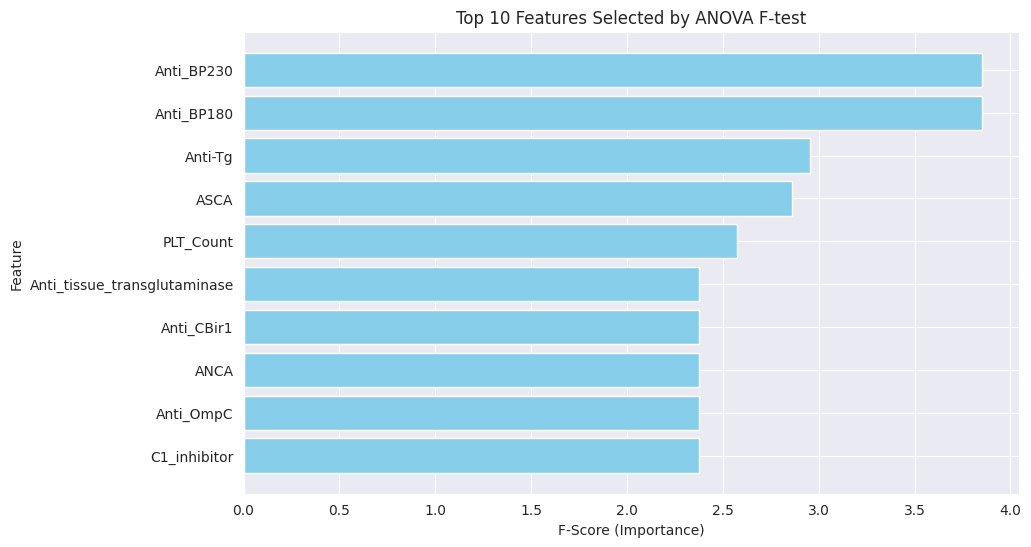

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Convert scaled features back to DataFrame with column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X_full.columns)

# Apply ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)  # select top 10 features
X_new = selector.fit_transform(X_scaled_df, y)

# Get selected feature names
selected_features_mask = selector.get_support()
selected_features = X_scaled_df.columns[selected_features_mask]
feature_scores = selector.scores_[selected_features_mask]

# Create dataframe of feature importance
feature_importance = pd.DataFrame({
    "Feature": selected_features,
    "F_Score": feature_scores
}).sort_values(by="F_Score", ascending=False)

print("--- Top 10 Selected Features ---")
print(feature_importance)

# Keep only selected features for ML
X_selected = X_scaled_df.loc[:, selected_features]

print("Shape after feature selection:", X_selected.shape)

# --- Visualization: Bar chart of top features ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["F_Score"], color="skyblue")
plt.xlabel("F-Score (Importance)")
plt.ylabel("Feature")
plt.title("Top 10 Features Selected by ANOVA F-test")
plt.gca().invert_yaxis()  # highest score at the top
plt.show()


**Verification Steps**

- Missing Value Check:

In [39]:
print("\nMissing values after imputation:")
print(df_clean.isnull())


Missing values after imputation:
         Age  Diagnosis  Sickness_Duration_Months  RBC_Count  Hemoglobin  \
0      False      False                     False      False       False   
1      False      False                     False      False       False   
2      False      False                     False      False       False   
3      False      False                     False      False       False   
4      False      False                     False      False       False   
...      ...        ...                       ...        ...         ...   
10117  False      False                     False      False       False   
10163  False      False                     False      False       False   
10179  False      False                     False      False       False   
10232  False      False                     False      False       False   
10483  False      False                     False      False       False   

       Hematocrit    MCV    MCH   MCHC    RDW  ...  p

# Random Forest Model
# 1. Data Splitting
**Configuration:**

- Test Size: 20% of data
- Random State: 42 (for reproducibility)
- Stratified Split: Maintains original class distribution
#2. Model Pipeline Setup
**Key Features:**

- Built-in imputation for data safety
- Reproducible random states

In [32]:
# --- 3. Train/Test Split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)



Train shape: (514, 76) | Test shape: (129, 76)


In [46]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt


# Encode target (Diagnosis)
le = LabelEncoder()
df["Diagnosis_encoded"] = le.fit_transform(df["Diagnosis"])

# --- 5. Train Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf_model.fit(X_train_scaled_df, y_train)

# --- 6. Predictions & Evaluation ---
y_pred = rf_model.predict(X_test_scaled_df)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n--- Evaluation Metrics (Full Feature Set) ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- 7. Feature Importances ---
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Show top 15
print("\n--- Top 15 Features by Importance ---")
print(feat_imp.head(15))

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"].head(15), feat_imp["Importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Random Forest - Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


NameError: name 'X_train_scaled_df' is not defined

# 3. Model Training and Evaluation Of Features and Carrying out Feature Selection


--- Evaluation Metrics ---
Accuracy : 0.3101
Precision: 0.1495
Recall   : 0.3101
F1 Score : 0.1904

--- Classification Report ---
                                    precision    recall  f1-score   support

               Autoimmune orchitis       0.12      0.06      0.08        33
                   Graves' disease       0.00      0.00      0.00        16
              Rheumatoid arthritis       0.00      0.00      0.00        18
                  Sjögren syndrome       0.00      0.00      0.00        17
Systemic lupus erythematosus (SLE)       0.34      0.84      0.49        45

                          accuracy                           0.31       129
                         macro avg       0.09      0.18      0.11       129
                      weighted avg       0.15      0.31      0.19       129


--- Top 15 Features by Importance ---
                     Feature  Importance
1   Sickness_Duration_Months    0.041537
6                        MCH    0.039323
14               Eos

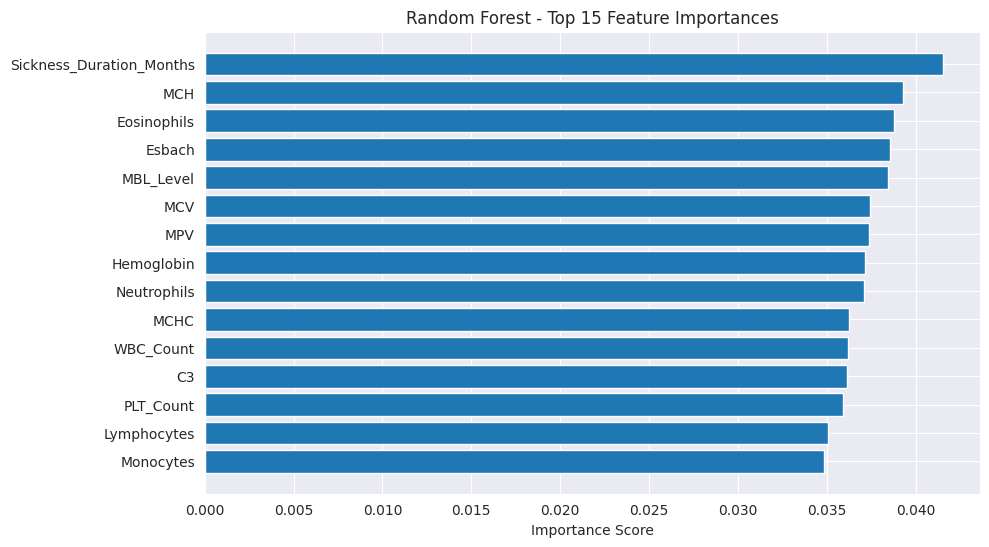

In [33]:
# --- 4. Train Random Forest ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)

# --- 5. Predictions & Evaluation ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n--- Evaluation Metrics ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))


# --- 6. Feature Importances ---
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_scaled_df.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Show top 15
print("\n--- Top 15 Features by Importance ---")
print(feat_imp.head(15))

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"].head(15), feat_imp["Importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Random Forest - Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
!pip install fastbook

#Retraining the Model using the top 15 Features


Top 15 Features used for retraining:
 ['Sickness_Duration_Months', 'MCH', 'Eosinophils', 'Esbach', 'MBL_Level', 'MCV', 'MPV', 'Hemoglobin', 'Neutrophils', 'MCHC', 'WBC_Count', 'C3', 'PLT_Count', 'Lymphocytes', 'Monocytes']

--- Evaluation Metrics (Retrained on Top 15 features) ---
Accuracy : 0.3488
Precision: 0.2055
Recall   : 0.3488
F1 Score : 0.2507

--- Classification Report ---
                                    precision    recall  f1-score   support

               Autoimmune orchitis       0.27      0.24      0.25        33
                   Graves' disease       0.00      0.00      0.00        16
              Rheumatoid arthritis       0.00      0.00      0.00        18
                  Sjögren syndrome       0.00      0.00      0.00        17
Systemic lupus erythematosus (SLE)       0.39      0.82      0.53        45

                          accuracy                           0.35       129
                         macro avg       0.13      0.21      0.16       129
    

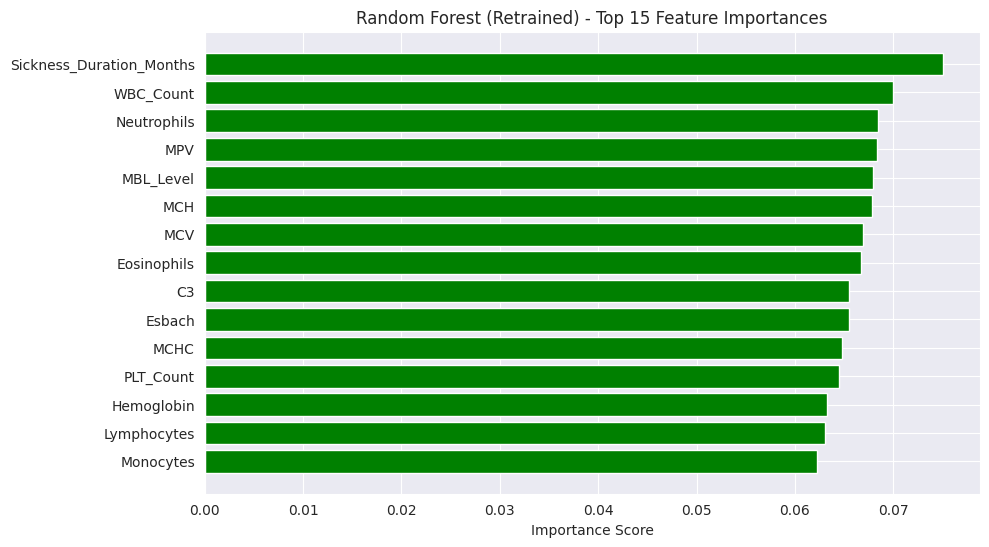

In [34]:
# --- 1. Select Top 15 Features from Feature Importances ---
top_features = feat_imp["Feature"].head(15).tolist()
print("\nTop 15 Features used for retraining:\n", top_features)

# Keep only top 15 features
X_top15 = X_scaled_df[top_features]

# --- 2. Split into Training and Testing Sets ---
from sklearn.model_selection import train_test_split

X_train_top15, X_test_top15, y_train, y_test = train_test_split(
    X_top15, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Retrain Random Forest on Top 15 Features ---
rf_top15 = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_top15.fit(X_train_top15, y_train)

# --- 4. Predictions & Evaluation ---
y_pred_top15 = rf_top15.predict(X_test_top15)

accuracy = accuracy_score(y_test, y_pred_top15)
precision = precision_score(y_test, y_pred_top15, average="weighted")
recall = recall_score(y_test, y_pred_top15, average="weighted")
f1 = f1_score(y_test, y_pred_top15, average="weighted")

print("\n--- Evaluation Metrics (Retrained on Top 15 features) ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred_top15, target_names=le.classes_))

# --- 5. Feature Importances (Retrained Model) ---
importances_top15 = rf_top15.feature_importances_
feat_imp_top15 = pd.DataFrame({"Feature": top_features, "Importance": importances_top15})
feat_imp_top15 = feat_imp_top15.sort_values(by="Importance", ascending=False)

print("\n--- Feature Importances (Retrained RF on Top 15) ---")
print(feat_imp_top15)

# --- 6. Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_top15["Feature"], feat_imp_top15["Importance"], color="green")
plt.gca().invert_yaxis()
plt.title("Random Forest (Retrained) - Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


# SHAP Explainability

Generating SHAP Summary Plot (Global Feature Importance)...


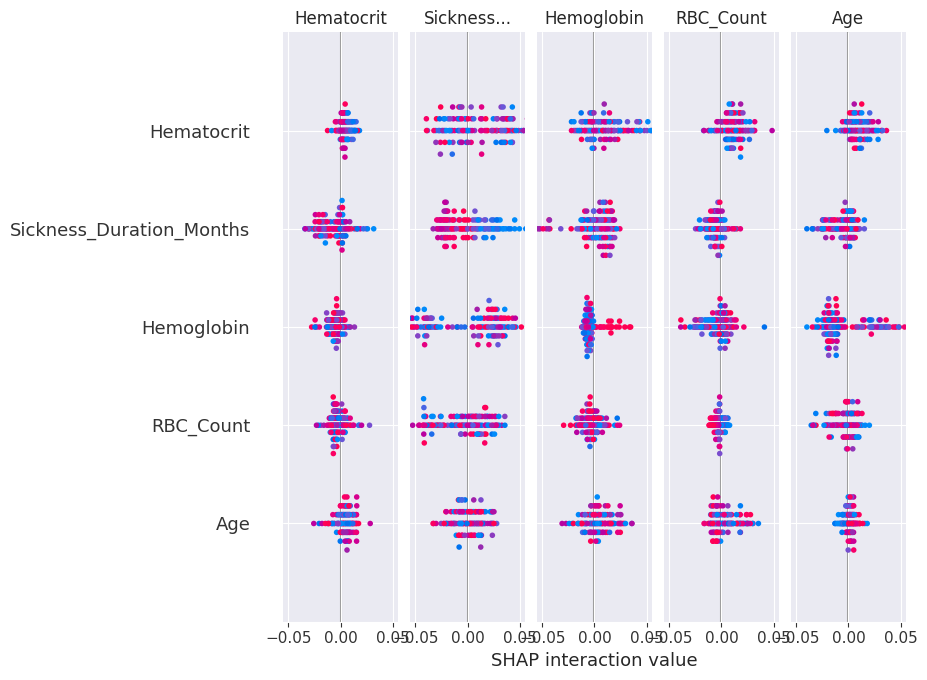

Generating SHAP Force Plot (Local Explanation for 1 patient)...


DimensionError: Length of features is not equal to the length of shap_values!

In [35]:
# --- SHAP Explainability ---
import shap

# Initialize TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# --- Global Explanations ---
# Summary plot: shows which features matter most overall
print("Generating SHAP Summary Plot (Global Feature Importance)...")
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# --- Local Explanations ---
# Force plot for a single patient (e.g., first sample in test set)
print("Generating SHAP Force Plot (Local Explanation for 1 patient)...")
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    X_test.iloc[0,:],
    matplotlib=True  # ensures it renders in Colab
)


**Hyperparameter Tuning**

In [40]:
# I did Feature selection even with the top 30 Features but the models performance did
# not seem to change even after tuning thus I opted for Dimensionality Reduction so as to be able to assess the models performance then

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# --- Select Top N Features ---
top_n = 30   # try 30 first, then 40
top_features = feat_imp["Feature"].head(top_n).tolist()
X_topN = X_scaled_df[top_features]

# --- Train/Test Split ---
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_topN, y, test_size=0.2, stratify=y, random_state=42
)

# --- Hyperparameter Tuning ---
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=2
)
grid_search.fit(X_train_top, y_train_top)

# --- Best Model ---
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# --- Evaluate ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_top = best_rf.predict(X_test_top)

accuracy = accuracy_score(y_test_top, y_pred_top)
precision = precision_score(y_test_top, y_pred_top, average="weighted")
recall = recall_score(y_test_top, y_pred_top, average="weighted")
f1 = f1_score(y_test_top, y_pred_top, average="weighted")

print("\n--- Evaluation Metrics (Top", top_n, "Features) ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test_top, y_pred_top, target_names=le.classes_))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

--- Evaluation Metrics (Top 30 Features) ---
Accuracy : 0.2326
Precision: 0.1881
Recall   : 0.2326
F1 Score : 0.1950

--- Classification Report ---
                                    precision    recall  f1-score   support

               Autoimmune orchitis       0.06      0.06      0.06        33
                   Graves' disease       0.00      0.00      0.00        16
              Rheumatoid arthritis       0.25      0.11      0.15        18
                  Sjögren syndrome       0.14      0.06      0.08        17
Systemic lupus erythematosus (SLE)       0.34      0.56      0.42        45

                          accuracy                           0.23       129
                         macro avg       0.16      0.16      0.14       129
                      weighted avg       0.19     

# PCA Dimensionality Reduction + Random Forest

Original features: 76
Reduced PCA components: 53

--- Evaluation Metrics (PCA Features) ---
Accuracy : 0.3643
Precision: 0.2225
Recall   : 0.3643
F1 Score : 0.2437

--- Classification Report ---
                                    precision    recall  f1-score   support

               Autoimmune orchitis       0.38      0.18      0.24        33
                   Graves' disease       0.00      0.00      0.00        16
              Rheumatoid arthritis       0.00      0.00      0.00        18
                  Sjögren syndrome       0.00      0.00      0.00        17
Systemic lupus erythematosus (SLE)       0.36      0.91      0.52        45

                          accuracy                           0.36       129
                         macro avg       0.15      0.22      0.15       129
                      weighted avg       0.22      0.36      0.24       129



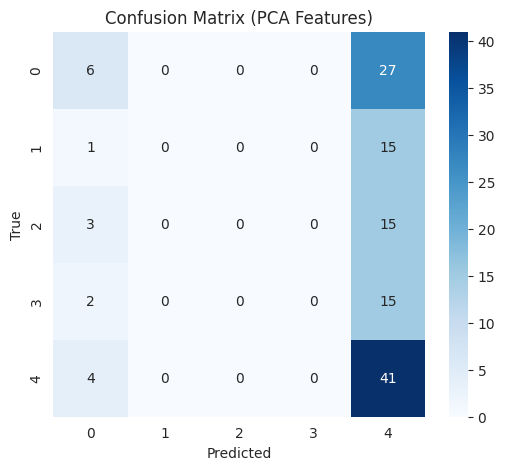

In [42]:
# Compress your 76 features into fewer principal components (usually ~20–30).

# Retrain Random Forest on those components.

# Print metrics + show confusion matrix.

# --- PCA Dimensionality Reduction + Random Forest ---

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Apply PCA (keep enough components to explain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)

print("Original features:", X_scaled_df.shape[1])
print("Reduced PCA components:", X_pca.shape[1])

# 2. Split data again
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train Random Forest on PCA features
rf_pca = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf_pca.fit(X_train_pca, y_train_pca)

# 4. Predictions & Evaluation
y_pred_pca = rf_pca.predict(X_test_pca)

accuracy = accuracy_score(y_test_pca, y_pred_pca)
precision = precision_score(y_test_pca, y_pred_pca, average="weighted")
recall = recall_score(y_test_pca, y_pred_pca, average="weighted")
f1 = f1_score(y_test_pca, y_pred_pca, average="weighted")

print("\n--- Evaluation Metrics (PCA Features) ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test_pca, y_pred_pca, target_names=le.classes_))

# 5. Confusion Matrix Visualization
cm = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (PCA Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
